# Imports

In [1]:

import numpy as np
import pandas as pd
import cv2
import os
import tensorflow as tf

from zipfile import ZipFile
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout


In [34]:
if os.path.exists('./model.h5'):
    model = tf.keras.models.load_model('./model.h5')

if os.path.exists('./model_enhanced.h5'):
    model_enhanced = tf.keras.models.load_model('./model_enhanced.h5')


# Dataset Download

In [3]:
# download the dataset
# make sure you have your kaggle api key on the system
!kaggle competitions download -c dogs-vs-cats

dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


# Data Preparation

In [5]:
# define some files and dirs
home_dir = os.path.expanduser('.')
dvc_zip = os.path.expanduser('./dogs-vs-cats.zip')

test1_zip = os.path.expanduser('./test1.zip')
train_zip = os.path.expanduser('./train.zip')

test1 = os.path.expanduser('./test1')
train = os.path.expanduser('./train')

In [6]:
# unzip the files
if not (os.path.exists(test1_zip) and os.path.exists(train_zip)):
    with ZipFile(dvc_zip) as z:
        z.extractall(path=home_dir)

if not os.path.exists(test1):
    with ZipFile(test1_zip) as z:
        z.extractall(path=home_dir)
        
if not os.path.exists(train):
    with ZipFile(train_zip) as z:
        z.extractall(path=home_dir)

## Train Data

In [7]:
# create a list for the full dataset
x_list = list()
y_list = list()

for f in os.listdir(train):
    if f.startswith('dog'):
        y_list.append([1])
    elif f.startswith('cat'):
        y_list.append([0])
    
    # load image file and set their size to 128 * 128
    img_file = train + '/' + f
    img = cv2.resize(cv2.imread(img_file), (128, 128))
    
    x_list.append(img)

# convert train list to array
x_full_ds = np.array(x_list, dtype='float16')
y_full_ds = np.array(y_list, dtype='float16')

# delete the lists
del x_list
del y_list

print(x_full_ds.shape)
print(y_full_ds.shape)


(25000, 128, 128, 3)
(25000, 1)


In [8]:
# convert train labels to categorical arrays
y_full_ds = to_categorical(y_full_ds)

y_full_ds

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [9]:
# normalize training data
x_full_ds = x_full_ds / 255.0
x_full_ds


array([[[[0.1804  , 0.1333  , 0.0941  ],
         [0.2157  , 0.1412  , 0.0902  ],
         [0.2942  , 0.204   , 0.1412  ],
         ...,
         [0.863   , 0.706   , 0.608   ],
         [0.9214  , 0.7607  , 0.6626  ],
         [0.9136  , 0.749   , 0.643   ]],

        [[0.1608  , 0.1137  , 0.0706  ],
         [0.204   , 0.1294  , 0.0784  ],
         [0.2627  , 0.1726  , 0.1098  ],
         ...,
         [0.8745  , 0.714   , 0.612   ],
         [0.8706  , 0.71    , 0.608   ],
         [0.9097  , 0.749   , 0.651   ]],

        [[0.149   , 0.102   , 0.06274 ],
         [0.1921  , 0.1177  , 0.06665 ],
         [0.2666  , 0.1765  , 0.1137  ],
         ...,
         [0.8237  , 0.651   , 0.537   ],
         [0.851   , 0.6943  , 0.5845  ],
         [0.9136  , 0.757   , 0.6665  ]],

        ...,

        [[0.251   , 0.1412  , 0.1098  ],
         [0.2079  , 0.1177  , 0.08234 ],
         [0.1647  , 0.102   , 0.0549  ],
         ...,
         [0.3215  , 0.2196  , 0.1569  ],
         [0.3254  , 0.

## Prediction Data

In [18]:
# create a list for the full dataset
x_pred_list = list()

for f in os.listdir(test1):
    # load image file and set their size to 128 * 128
    img_file = test1 + '/' + f
    img = cv2.resize(cv2.imread(img_file), (128, 128))
    
    x_pred_list.append(img)

# convert train list to array
x_pred_ds = np.array(x_pred_list, dtype='float16')

# delete the prediction list
del x_pred_list

print(x_pred_ds.shape)

# normalize data
x_pred_ds = x_pred_ds / 255.0

(12500, 128, 128, 3)


## Split Train, Validate, and Test Data

We will split the data into three datasets:
1. Train dataset (x_train, y_train)
2. Validation dataset (x_val, y_val)
3. Test dataset (x_test, y_test)

The test dataset will be used to evaluate the models at the end of its training.

In [10]:
# split the full dataset to train and validation
x_train, x_val, y_train, y_val = train_test_split(
    x_full_ds, y_full_ds, test_size=0.2, random_state=0)

# split the validation dataset to validation and test
x_val, x_test, y_val, y_test = train_test_split(
    x_val, y_val, test_size=0.5, random_state=0)

# delete the full datasets - conserve memory
del x_full_ds
del y_full_ds

# CNN Models

## Baseline model

In [10]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',
        kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
model.add(Conv2D(32, (3, 3), activation='relu',
        kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(2, activation='softmax'))

# compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model.summary()


2022-12-26 20:54:21.896415: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-26 20:54:21.897828: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: AMD Radeon Pro 5500M

systemMemory: 32.00 GB
maxCacheSize: 3.99 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 128)               16777344  
                                                                 
 dense_1 (Dense)             (Non

In [11]:
history = model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(x_val, y_val),
    verbose=1)


Epoch 1/20


2022-12-26 20:54:35.476108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 1.5467 - accuracy: 0.6104

2022-12-26 20:55:15.134168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 43s 131ms/step - loss: 1.5467 - accuracy: 0.6104 - val_loss: 0.5824 - val_accuracy: 0.6860
Epoch 2/20
313/313 [==============================] - 41s 130ms/step - loss: 0.5097 - accuracy: 0.7527 - val_loss: 0.5368 - val_accuracy: 0.7228
Epoch 3/20
313/313 [==============================] - 41s 132ms/step - loss: 0.3845 - accuracy: 0.8267 - val_loss: 0.5700 - val_accuracy: 0.7244
Epoch 4/20
313/313 [==============================] - 42s 134ms/step - loss: 0.2670 - accuracy: 0.8907 - val_loss: 0.6255 - val_accuracy: 0.7332
Epoch 5/20
313/313 [==============================] - 41s 131ms/step - loss: 0.1598 - accuracy: 0.9397 - val_loss: 0.7234 - val_accuracy: 0.7320
Epoch 6/20
313/313 [==============================] - 41s 131ms/step - loss: 0.0883 - accuracy: 0.9717 - val_loss: 0.8971 - val_accuracy: 0.7436
Epoch 7/20
313/313 [==============================] - 41s 132ms/step - loss: 0.0518 - accuracy: 0.9847 - val_loss: 1.0755 - val_accuracy: 0.7

In [35]:
# evaluate the model accuracy
loss, acc = model.evaluate(x_test, y_test, verbose=1)
print(' Model accuracy: {:5.2f}%'.format(100 * acc))


 1/79 [..............................] - ETA: 19s - loss: 0.6785 - accuracy: 0.8438

2022-12-26 22:29:55.739116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 3s 35ms/step - loss: 1.7578 - accuracy: 0.7416
 Model accuracy: 74.16%


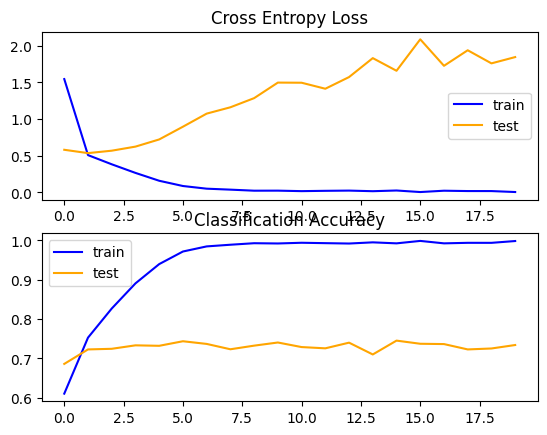

In [13]:
# plot crossentropy losses
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.plot(history.history['val_loss'], color='orange', label='test')
pyplot.legend()
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['accuracy'], color='blue', label='train')
pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
pyplot.legend()


In [14]:
# save model
model.save('model.h5')

### Prediction

In [36]:
# predict the labels
y_pred = model.predict(x_pred_ds)

  5/391 [..............................] - ETA: 10s

2022-12-26 22:30:08.881303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


391/391 [==============================] - 12s 29ms/step


In [37]:
y_pred.shape

(12500, 2)

In [38]:
# create a dataframe with two columns, test image filename and prediction label
df = pd.DataFrame()
filename = []
label = []
for i in zip(os.listdir(test1), y_pred):
    filename.append(i[0])
    label.append('Dog' if i[1][1] > i[1][0] else 'Cat')

df['Filename'] = filename
df['Label'] = label

df.head()

df.to_csv('model_predictions.csv')

## Enhanced Model

In [22]:
model_enhanced = Sequential()
model_enhanced.add(Conv2D(32, (3, 3), activation='relu',
                            kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
model_enhanced.add(BatchNormalization())
model_enhanced.add(Conv2D(32, (3, 3), activation='relu',
                            kernel_initializer='he_uniform', padding='same'))
model_enhanced.add(BatchNormalization())
model_enhanced.add(MaxPooling2D((2, 2)))
model_enhanced.add(Dropout(0.2))
model_enhanced.add(Conv2D(64, (3, 3), activation='relu',
                            kernel_initializer='he_uniform', padding='same'))
model_enhanced.add(BatchNormalization())
model_enhanced.add(Conv2D(64, (3, 3), activation='relu',
                            kernel_initializer='he_uniform', padding='same'))
model_enhanced.add(BatchNormalization())
model_enhanced.add(MaxPooling2D((2, 2)))
model_enhanced.add(Dropout(0.3))
model_enhanced.add(Conv2D(128, (3, 3), activation='relu',
                            kernel_initializer='he_uniform', padding='same'))
model_enhanced.add(BatchNormalization())
model_enhanced.add(Conv2D(128, (3, 3), activation='relu',
                            kernel_initializer='he_uniform', padding='same'))
model_enhanced.add(BatchNormalization())
model_enhanced.add(MaxPooling2D((2, 2)))
model_enhanced.add(Dropout(0.4))
model_enhanced.add(Flatten())
model_enhanced.add(Dense(128, activation='relu',
                    kernel_initializer='he_uniform'))
model_enhanced.add(BatchNormalization())
model_enhanced.add(Dropout(0.5))
model_enhanced.add(Dense(2, activation='softmax'))

# compile model
model_enhanced.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])


In [23]:
model_enhanced.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                      

In [24]:
datagen = ImageDataGenerator(
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.1)

# prepare iterator
it_train = datagen.flow(x_train, y_train, batch_size=32)

In [25]:
# fit model
steps = int(x_train.shape[0] / 32)
history_enhanced = model_enhanced.fit(
    it_train,
    steps_per_epoch=steps,
    epochs=20,
    # validation_data=(it_x_test, it_y_test),
    validation_data=(x_val, y_val),
    verbose=1)

Epoch 1/20


2022-12-26 21:18:00.226272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - ETA: 0s - loss: 0.6894 - accuracy: 0.6435

2022-12-26 21:19:15.371975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 80s 124ms/step - loss: 0.6894 - accuracy: 0.6435 - val_loss: 0.6200 - val_accuracy: 0.6744
Epoch 2/20
625/625 [==============================] - 82s 131ms/step - loss: 0.5362 - accuracy: 0.7311 - val_loss: 0.5273 - val_accuracy: 0.7464
Epoch 3/20
625/625 [==============================] - 86s 138ms/step - loss: 0.4762 - accuracy: 0.7727 - val_loss: 0.5311 - val_accuracy: 0.7624
Epoch 4/20
625/625 [==============================] - 86s 137ms/step - loss: 0.4119 - accuracy: 0.8144 - val_loss: 0.4076 - val_accuracy: 0.8212
Epoch 5/20
625/625 [==============================] - 89s 143ms/step - loss: 0.3437 - accuracy: 0.8488 - val_loss: 0.3897 - val_accuracy: 0.8364
Epoch 6/20
625/625 [==============================] - 89s 142ms/step - loss: 0.2965 - accuracy: 0.8741 - val_loss: 1.5412 - val_accuracy: 0.6448
Epoch 7/20
625/625 [==============================] - 90s 144ms/step - loss: 0.2635 - accuracy: 0.8876 - val_loss: 0.3131 - val_accuracy: 0.8

In [13]:
# evaluate the model accuracy
loss, acc = model_enhanced.evaluate(x_test, y_test, verbose=1)
print('Model accuracy: {:5.2f}%'.format(100 * acc))


79/79 [==============================] - 3s 40ms/step - loss: 0.1584 - accuracy: 0.9328
Model accuracy: 93.28%


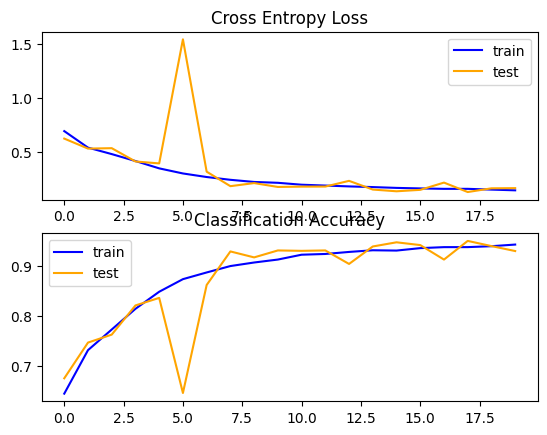

In [27]:
# plot crossentropy losses
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history_enhanced.history['loss'], color='blue', label='train')
pyplot.plot(history_enhanced.history['val_loss'], color='orange', label='test')
pyplot.legend()
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history_enhanced.history['accuracy'], color='blue', label='train')
pyplot.plot(history_enhanced.history['val_accuracy'], color='orange', label='test')
pyplot.legend()


In [28]:
model_enhanced.save('model_enhanced.h5')

### Prediction

In [31]:
# predict the labels
y_pred = model_enhanced.predict(x_pred_ds)

391/391 [==============================] - 14s 35ms/step


In [32]:
y_pred.shape

(12500, 2)

In [33]:
# create a dataframe with two columns, test image filename and prediction label
df = pd.DataFrame()
filename = []
label = []
for i in zip(os.listdir(test1), y_pred):
    filename.append(i[0])
    label.append('Dog' if i[1][1] > i[1][0] else 'Cat')

df['Filename'] = filename
df['Label'] = label

df.head()

df.to_csv('model_enhanced_predictions.csv')

## Transfer Learning

In [39]:
pass